In [ ]:
# ============================================================================
# Aureus Sigma Capital - Phase 27a: Official Baseline v1.1 (Corrected)
# Notebook: 27a_official_baseline_v1.1_corrected.ipynb
#
# Objective:
#   To establish the single, definitive, and immutable performance baseline
#   using a backtesting engine that is free from look-ahead bias and signal
#   dilution errors. The results of this backtest will serve as the
#   "Official Baseline v1.1" against which all subsequent enhancements will
#   be measured.
#
# Critical Fixes Implemented:
#   1.  **Look-Ahead Bias:** The universe constructor now uses a T-1 data
#       window, ensuring today's trading decisions are based only on
#       yesterday's information.
#   2.  **Signal Dilution:** The engine now uses a `scores_already_z` flag
#       to prevent the double-normalization of pre-calculated z-scores.
# ============================================================================

In [1]:
# ============================================================================
# CELL 1: SETUP & CONFIGURATION
# ============================================================================

# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from pathlib import Path
import sys
import yaml

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# --- Add Project Root to Python Path ---
try:
    current_path = Path.cwd()
    while not (current_path / 'production').is_dir():
        if current_path.parent == current_path: raise FileNotFoundError("Could not find 'production' directory.")
        current_path = current_path.parent
    project_root = current_path
    if str(project_root) not in sys.path: sys.path.insert(0, str(project_root))
    from production.universe.constructors import get_liquid_universe_dataframe
    print(f"✅ Successfully imported production modules (v1.1 Patched).")
    print(f"   - Project Root set to: {project_root}")
except (ImportError, FileNotFoundError) as e:
    print(f"❌ ERROR: Could not import production modules: {e}")
    raise

# --- Official Baseline v1.1 Configuration ---
BASELINE_V1_1_CONFIG = {
    "strategy_name": "Official_Baseline_v1.1_Value",
    "backtest_start_date": "2016-03-01",
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "transaction_cost_bps": 30,
    "scores_already_z": True, # <-- CRITICAL FIX 2
    "universe": {
        "lookback_days": 63,
        "adtv_threshold_bn": 10.0,
        "top_n": 200,
        "min_trading_coverage": 0.6,
    },
    "signal": {
        "factors_to_combine": {'Value_Composite': 1.0},
        "db_strategy_version": "qvm_v2.0_enhanced"
    },
    "portfolio": {
        "construction_method": "hybrid",
        "portfolio_size_small_universe": 20,
        "selection_percentile": 0.8,
    }
}

print("\n⚙️  Official Baseline v1.1 Configuration Loaded:")
print(f"   - Strategy: {BASELINE_V1_1_CONFIG['strategy_name']}")
print(f"   - Look-Ahead Bias Patch: ACTIVE (via constructors.py v1.1)")
print(f"   - Signal Dilution Patch: ACTIVE (scores_already_z = True)")

# --- Database Connection ---
def create_db_connection(project_root_path: Path):
    try:
        config_path = project_root_path / 'config' / 'database.yml'
        with open(config_path, 'r') as f: db_config = yaml.safe_load(f)['production']
        connection_string = (f"mysql+pymysql://{db_config['username']}:{db_config['password']}@{db_config['host']}/{db_config['schema_name']}")
        engine = create_engine(connection_string, pool_pre_ping=True)
        with engine.connect() as conn: conn.execute(text("SELECT 1"))
        print(f"\n✅ Database connection established successfully.")
        return engine
    except Exception as e:
        print(f"❌ FAILED to connect to the database: {e}")
        return None

engine = create_db_connection(project_root)
if engine is None: raise ConnectionError("Database connection failed.")

✅ Successfully imported production modules (v1.1 Patched).
   - Project Root set to: /Users/ducnguyen/Library/CloudStorage/GoogleDrive-duc.nguyentcb@gmail.com/My Drive/quant-world-invest/factor_investing_project

⚙️  Official Baseline v1.1 Configuration Loaded:
   - Strategy: Official_Baseline_v1.1_Value
   - Look-Ahead Bias Patch: ACTIVE (via constructors.py v1.1)
   - Signal Dilution Patch: ACTIVE (scores_already_z = True)

✅ Database connection established successfully.


In [2]:
# ============================================================================
# CELL 2: DATA INGESTION
# ============================================================================

# This cell remains identical to the previous version
def load_all_data_for_backtest(config: dict, db_engine):
    start_date = config['backtest_start_date']; end_date = config['backtest_end_date']
    db_version = config['signal']['db_strategy_version']
    buffer_start_date = pd.Timestamp(start_date) - pd.DateOffset(months=3)
    print(f"📂 Loading all data for period: {buffer_start_date.date()} to {end_date}...")
    db_params = {'start_date': buffer_start_date, 'end_date': pd.Timestamp(end_date), 'strategy_version': db_version}
    factor_query = text("SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite FROM factor_scores_qvm WHERE date BETWEEN :start_date AND :end_date AND strategy_version = :strategy_version")
    factor_data = pd.read_sql(factor_query, db_engine, params=db_params, parse_dates=['date'])
    price_query = text("SELECT date, ticker, close FROM equity_history WHERE date BETWEEN :start_date AND :end_date")
    price_data = pd.read_sql(price_query, db_engine, params=db_params, parse_dates=['date'])
    benchmark_query = text("SELECT date, close FROM etf_history WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date")
    benchmark_data = pd.read_sql(benchmark_query, db_engine, params=db_params, parse_dates=['date'])
    price_data['return'] = price_data.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data.pivot(index='date', columns='ticker', values='return')
    benchmark_returns = benchmark_data.set_index('date')['close'].pct_change().rename('VN-Index')
    print("   ✅ Data preparation complete.")
    return factor_data, daily_returns_matrix, benchmark_returns

factor_data_raw, daily_returns_matrix, benchmark_returns = load_all_data_for_backtest(BASELINE_V1_1_CONFIG, engine)

📂 Loading all data for period: 2015-12-01 to 2025-07-28...
   ✅ Data preparation complete.


In [3]:
# ============================================================================
# CELL 3: CORRECTED BASELINE PORTFOLIO ENGINE
# ============================================================================

class BaselinePortfolioEngine_v1_1:
    def __init__(self, config: dict, factor_data: pd.DataFrame, returns_matrix: pd.DataFrame,
                 benchmark_returns: pd.Series, db_engine):
        self.config = config; self.engine = db_engine
        start = pd.Timestamp(config['backtest_start_date']); end = pd.Timestamp(config['backtest_end_date'])
        self.factor_data_raw = factor_data[factor_data['date'].between(start, end)].copy()
        self.daily_returns_matrix = returns_matrix.loc[start:end].copy()
        self.benchmark_returns = benchmark_returns.loc[start:end].copy()
        print("✅ BaselinePortfolioEngine v1.1 (Corrected) initialized.")

    def run_backtest(self) -> (pd.Series, pd.DataFrame):
        print("\n🚀 Starting corrected baseline backtest execution...")
        rebalance_dates = self._generate_rebalance_dates()
        daily_holdings, diagnostics = self._run_backtesting_loop(rebalance_dates)
        net_returns = self._calculate_net_returns(daily_holdings)
        print("✅ Corrected baseline backtest execution complete.")
        return net_returns, diagnostics

    def _generate_rebalance_dates(self) -> list:
        all_trading_dates = self.daily_returns_matrix.index
        rebal_dates_calendar = pd.date_range(start=self.config['backtest_start_date'], end=self.config['backtest_end_date'], freq=self.config['rebalance_frequency'])
        actual_rebal_dates = [all_trading_dates[all_trading_dates.searchsorted(d, side='left')-1] for d in rebal_dates_calendar if d >= all_trading_dates.min()]
        return sorted(list(set(actual_rebal_dates)))

    def _run_backtesting_loop(self, rebalance_dates: list) -> (pd.DataFrame, pd.DataFrame):
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        diagnostics_log = []
        for i, rebal_date in enumerate(rebalance_dates):
            print(f"   - Processing rebalance {i+1}/{len(rebalance_dates)}: {rebal_date.date()}...", end="")
            universe_df = get_liquid_universe_dataframe(rebal_date, self.engine, self.config['universe'])
            if universe_df.empty: print(" ⚠️ Universe empty."); continue
            factors_on_date = self.factor_data_raw[self.factor_data_raw['date'] == rebal_date]
            liquid_factors = factors_on_date[factors_on_date['ticker'].isin(universe_df['ticker'])].copy()
            if len(liquid_factors) < 10: print(f" ⚠️ Insufficient stocks ({len(liquid_factors)})."); continue
            target_portfolio = self._calculate_target_portfolio(liquid_factors)
            if target_portfolio.empty: print(" ⚠️ Portfolio empty."); continue
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = self.daily_returns_matrix.index[(self.daily_returns_matrix.index >= start_period) & (self.daily_returns_matrix.index <= end_period)]
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
            prev_holdings = daily_holdings.iloc[daily_holdings.index.get_loc(rebal_date, method='ffill') - 1] if i > 0 else pd.Series(dtype='float64')
            turnover = (target_portfolio - prev_holdings.reindex(target_portfolio.index).fillna(0)).abs().sum() / 2.0
            diagnostics_log.append({'date': rebal_date, 'universe_size': len(universe_df), 'portfolio_size': len(target_portfolio), 'turnover': turnover})
            print(f" ✅ Universe: {len(universe_df)}, Portfolio: {len(target_portfolio)}, Turnover: {turnover:.1%}")
        return daily_holdings, pd.DataFrame(diagnostics_log).set_index('date')

    def _calculate_target_portfolio(self, factors_df: pd.DataFrame) -> pd.Series:
        factors_to_combine = self.config['signal']['factors_to_combine']
        weighted_scores = []
        for factor, weight in factors_to_combine.items():
            scores = factors_df[factor]
            if self.config.get("scores_already_z", False):
                z_scores = scores
            else:
                mean, std = scores.mean(), scores.std()
                z_scores = (scores - mean) / std if std > 1e-8 else pd.Series(0.0, index=scores.index)
            weighted_scores.append(z_scores * weight)
        if not weighted_scores: return pd.Series(dtype='float64')
        factors_df['final_signal'] = pd.concat(weighted_scores, axis=1).sum(axis=1)
        universe_size = len(factors_df)
        if universe_size < 100:
            portfolio_size = self.config['portfolio']['portfolio_size_small_universe']
            selected_stocks = factors_df.nlargest(portfolio_size, 'final_signal')
        else:
            percentile = self.config['portfolio']['selection_percentile']
            score_cutoff = factors_df['final_signal'].quantile(percentile)
            selected_stocks = factors_df[factors_df['final_signal'] >= score_cutoff]
        if selected_stocks.empty: return pd.Series(dtype='float64')
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])

    def _calculate_net_returns(self, daily_holdings: pd.DataFrame) -> pd.Series:
        holdings_shifted = daily_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1)
        turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2.0
        costs = turnover * (self.config['transaction_cost_bps'] / 10000)
        net_returns = (gross_returns - costs).rename(self.config['strategy_name'])
        print(f"\n💸 Net returns calculated. Total Cost Drag: {gross_returns.sum() - net_returns.sum():.2%}")
        return net_returns

✅ BaselinePortfolioEngine v1.1 (Corrected) initialized.

🚀 Starting corrected baseline backtest execution...
   - Processing rebalance 1/38: 2016-03-30... ✅ Universe: 62, Portfolio: 20, Turnover: 50.0%
   - Processing rebalance 2/38: 2016-06-29... ✅ Universe: 71, Portfolio: 20, Turnover: 20.0%
   - Processing rebalance 3/38: 2016-09-29... ✅ Universe: 62, Portfolio: 20, Turnover: 30.0%
   - Processing rebalance 4/38: 2016-12-30... ✅ Universe: 57, Portfolio: 20, Turnover: 22.5%
   - Processing rebalance 5/38: 2017-03-30... ✅ Universe: 72, Portfolio: 20, Turnover: 20.0%
   - Processing rebalance 6/38: 2017-06-29... ✅ Universe: 88, Portfolio: 20, Turnover: 20.0%
   - Processing rebalance 7/38: 2017-09-29... ✅ Universe: 88, Portfolio: 20, Turnover: 22.5%
   - Processing rebalance 8/38: 2017-12-29... ✅ Universe: 97, Portfolio: 20, Turnover: 12.5%
   - Processing rebalance 9/38: 2018-03-30... ✅ Universe: 94, Portfolio: 20, Turnover: 15.0%
   - Processing rebalance 10/38: 2018-06-29... ✅ Unive

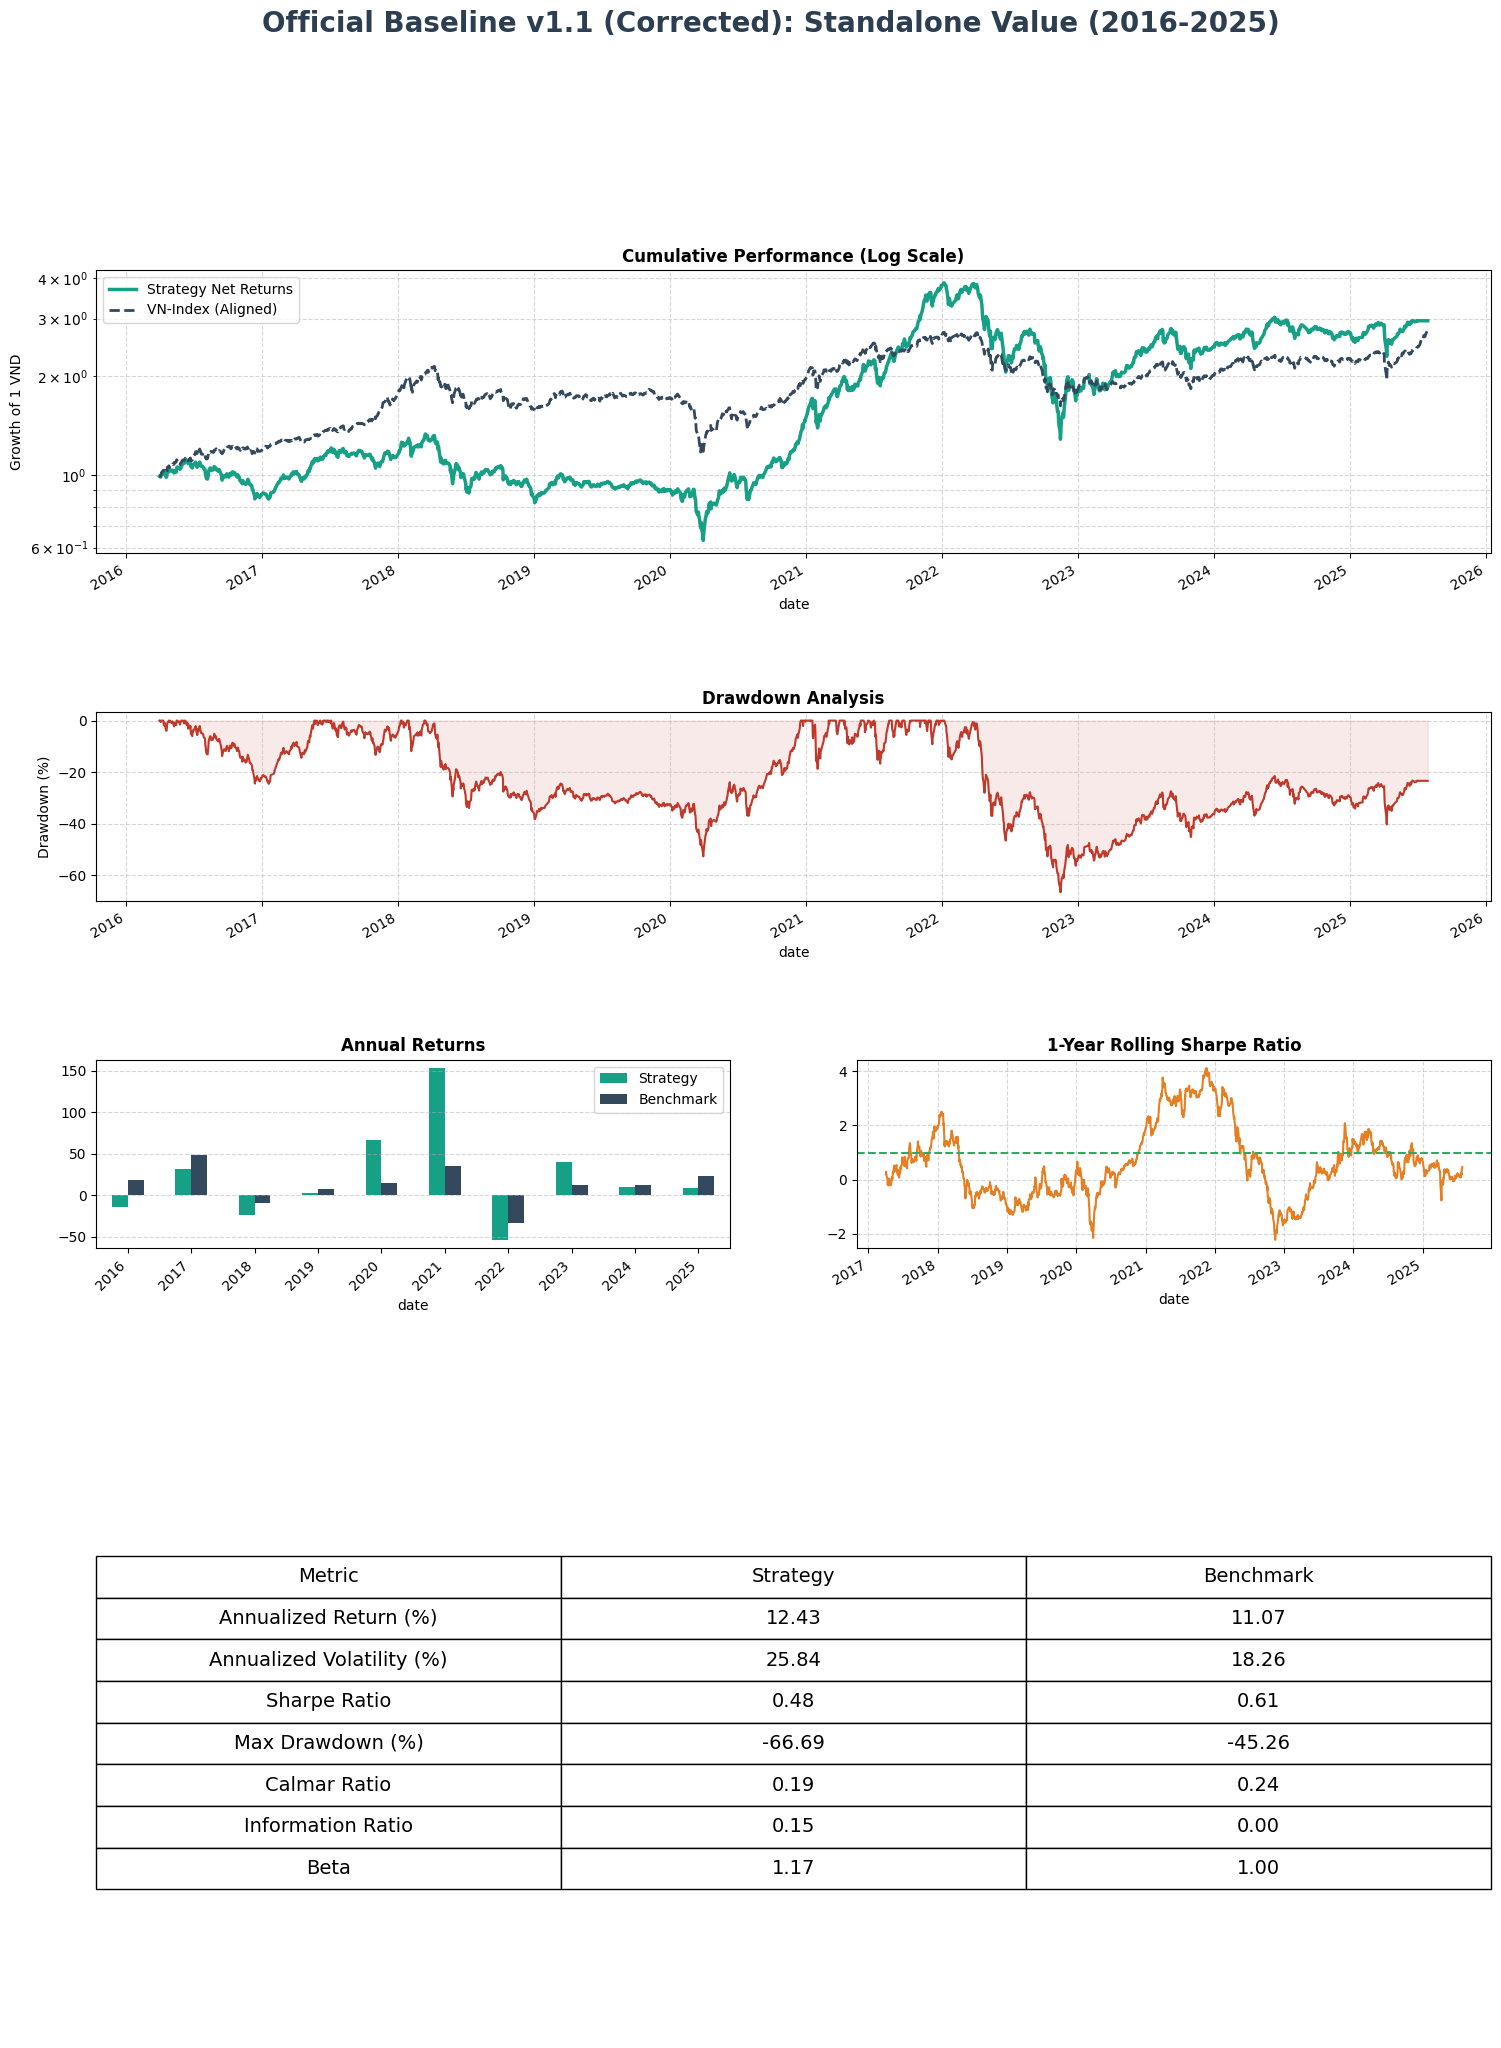

In [4]:
# ============================================================================
# CELL 4: EXECUTION & OFFICIAL BASELINE v1.1 REPORTING
# ============================================================================

# This cell remains identical to the previous version's analytics suite
def calculate_official_metrics(returns: pd.Series, benchmark: pd.Series, periods_per_year: int = 252) -> dict:
    first_trade_date = returns.loc[returns.ne(0)].index.min()
    if pd.isna(first_trade_date): return {metric: 0.0 for metric in ['Annualized Return (%)', 'Annualized Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Calmar Ratio', 'Information Ratio', 'Beta']}
    aligned_returns = returns.loc[first_trade_date:]; aligned_benchmark = benchmark.loc[first_trade_date:]
    n_years = len(aligned_returns) / periods_per_year
    annualized_return = ((1 + aligned_returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0
    annualized_volatility = aligned_returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0.0
    cumulative_returns = (1 + aligned_returns).cumprod(); max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min(); calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0.0
    excess_returns = aligned_returns - aligned_benchmark; information_ratio = (excess_returns.mean() * periods_per_year) / (excess_returns.std() * np.sqrt(periods_per_year)) if excess_returns.std() > 0 else 0.0
    beta = aligned_returns.cov(aligned_benchmark) / aligned_benchmark.var() if aligned_benchmark.var() > 0 else 0.0
    return {'Annualized Return (%)': annualized_return * 100, 'Annualized Volatility (%)': annualized_volatility * 100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown (%)': max_drawdown * 100, 'Calmar Ratio': calmar_ratio, 'Information Ratio': information_ratio, 'Beta': beta}

def generate_official_tearsheet(strategy_returns: pd.Series, benchmark_returns: pd.Series, diagnostics: pd.DataFrame, title: str):
    first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min()
    aligned_strategy_returns = strategy_returns.loc[first_trade_date:]; aligned_benchmark_returns = benchmark_returns.loc[first_trade_date:]
    strategy_metrics = calculate_official_metrics(strategy_returns, benchmark_returns); benchmark_metrics = calculate_official_metrics(benchmark_returns, benchmark_returns)
    fig = plt.figure(figsize=(18, 26)); gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.2], hspace=0.7, wspace=0.2); fig.suptitle(title, fontsize=20, fontweight='bold', color='#2C3E50')
    ax1 = fig.add_subplot(gs[0, :]); (1 + aligned_strategy_returns).cumprod().plot(ax=ax1, label='Strategy Net Returns', color='#16A085', lw=2.5); (1 + aligned_benchmark_returns).cumprod().plot(ax=ax1, label='VN-Index (Aligned)', color='#34495E', linestyle='--', lw=2); ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.set_ylabel('Growth of 1 VND'); ax1.set_yscale('log'); ax1.legend(loc='upper left'); ax1.grid(True, which='both', linestyle='--', alpha=0.5)
    ax2 = fig.add_subplot(gs[1, :]); drawdown = ((1 + aligned_strategy_returns).cumprod() / (1 + aligned_strategy_returns).cumprod().cummax() - 1) * 100; drawdown.plot(ax=ax2, color='#C0392B'); ax2.fill_between(drawdown.index, drawdown, 0, color='#C0392B', alpha=0.1); ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)'); ax2.grid(True, linestyle='--', alpha=0.5)
    ax3 = fig.add_subplot(gs[2, 0]); strat_annual = aligned_strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; bench_annual = aligned_benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=['#16A085', '#34495E']); ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold'); ax3.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax4 = fig.add_subplot(gs[2, 1]); rolling_sharpe = (aligned_strategy_returns.rolling(252).mean() * 252) / (aligned_strategy_returns.rolling(252).std() * np.sqrt(252)); rolling_sharpe.plot(ax=ax4, color='#E67E22'); ax4.axhline(1.0, color='#27AE60', linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold'); ax4.grid(True, linestyle='--', alpha=0.5)
    ax5 = fig.add_subplot(gs[3:, :]); ax5.axis('off'); summary_data = [['Metric', 'Strategy', 'Benchmark']];
    for key in strategy_metrics.keys(): summary_data.append([key, f"{strategy_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
    table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5)
    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

# --- Instantiate and Run the Corrected Baseline Engine ---
try:
    baseline_engine_v1_1 = BaselinePortfolioEngine_v1_1(
        config=BASELINE_V1_1_CONFIG,
        factor_data=factor_data_raw,
        returns_matrix=daily_returns_matrix,
        benchmark_returns=benchmark_returns,
        db_engine=engine
    )
    baseline_net_returns, baseline_diagnostics = baseline_engine_v1_1.run_backtest()

    print("\n" + "="*80)
    print("📊 OFFICIAL BASELINE V1.1 (CORRECTED): PERFORMANCE REPORT")
    print("="*80)
    generate_official_tearsheet(
        baseline_net_returns,
        benchmark_returns,
        baseline_diagnostics,
        "Official Baseline v1.1 (Corrected): Standalone Value (2016-2025)"
    )
except Exception as e:
    print(f"❌ An error occurred during the corrected baseline execution: {e}")
    raise